In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import tempfile
import tensorflow as tf

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl.controller import GreedyDiscreteDeepQ
from tf_rl.simulation import KarpathyGame
from tf_rl import simulate
from tf_rl.models import MLP

from __future__ import print_function

In [3]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/var/folders/z_/203rtb2d141_z05gbwlvwg6c009kh1/T/tmpkUDAmf


In [4]:
current_settings = {
    'objects': [
        'friend',
        'enemy',
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
    },
    'object_reward': {
        'friend': 0.1,
        'enemy': -0.1,
    },
    'hero_bounces_off_walls': False,
    'world_size': (700,500),
    'hero_initial_position': [400, 300],
    'hero_initial_speed':    [0,   0],
    "maximum_speed":         [50, 50],
    "object_radius": 10.0,
    "num_objects": {
        "friend" : 25,
        "enemy" :  25,
    },
    "num_observation_lines" : 32,
    "observation_line_length": 120.,
    "tolerable_distance_to_wall": 50,
    "wall_distance_penalty":  -0.0,
    "delta_v": 50
}

In [5]:
# create the game simulator
g = KarpathyGame(current_settings)

In [6]:
human_control = False

if human_control:
    # WSAD CONTROL (requires extra setup - check out README)
    current_controller = HumanController({b"w": 3, b"d": 0, b"s": 1,b"a": 2,}) 
else:
    # Tensorflow business - it is always good to reset a graph before creating a new controller.
    tf.reset_default_graph()
    #session = tf.InteractiveSession()
    session = tf.Session()
    session.as_default()

    # This little guy will let us run tensorboard
    #      tensorboard --logdir [LOG_DIR]
    journalist = tf.train.SummaryWriter(LOG_DIR)

    # Brain maps from observation to Q values for different actions.
    # Here it is a done using a multi layer perceptron with 2 hidden
    # layers
    brain = MLP([g.observation_size,], [200, 200, g.num_actions], 
                [tf.tanh, tf.tanh, tf.identity])
    
    # The optimizer to use. Here we use RMSProp as recommended
    # by the publication
    optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

    # DiscreteDeepQ object
    MAX_EXPLORATION = 5000
    current_controller = GreedyDiscreteDeepQ(g.observation_size, g.num_actions, brain, optimizer, session,
                                       discount_rate=0.99, exploration_period=MAX_EXPLORATION, max_experience=10000, 
                                       store_every_nth=4, train_every_nth=4,
                                       summary_writer=journalist, save_path=LOG_DIR+"/mlp.model.chkpt")
    
    session.run(tf.initialize_all_variables())
    session.run(current_controller.target_network_update)
    # graph was not available when journalist was created  
    journalist.add_graph(session.graph_def)

In [7]:
FPS          = 60
ACTION_EVERY = 3
    
fast_mode = True
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 20
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    with tf.device("/cpu:0"):
        simulate(simulation=g,
                 controller=current_controller,
                 fps=FPS,
                 visualize_every=VISUALIZE_EVERY,
                 action_every=ACTION_EVERY,
                 wait=WAIT,
                 disable_training=False,
                 simulation_resolution=0.001,
                 save_path=None,
                 max_frame=3000)
                 #max_frame=ACTION_EVERY*MAX_EXPLORATION)
except KeyboardInterrupt:
    print("Interrupted")

<tf_rl.utils.svg.Scene instance at 0x1069ed3b0>

('Reach max frames ', 3000)


In [9]:
session.run(current_controller.target_network_update)

In [10]:
current_controller.q_network.input_layer.Ws[0].eval()

array([[ 0.01869129,  0.07433749,  0.06537439, ...,  0.07108919,
        -0.04820396, -0.02483951],
       [ 0.01929374,  0.01235555,  0.01948987, ...,  0.03401808,
         0.00149753,  0.09830335],
       [-0.09667152, -0.01095846, -0.02119943, ..., -0.01686188,
        -0.01904194,  0.02635838],
       ..., 
       [ 0.05008407,  0.03221666,  0.01577369, ..., -0.03480808,
         0.047174  ,  0.01135619],
       [ 0.13096647,  0.01431789, -0.01003283, ..., -0.11416674,
         0.02905912,  0.01312845],
       [ 0.06738454, -0.09397013, -0.01244766, ...,  0.05848417,
         0.01971359,  0.02129664]], dtype=float32)

In [11]:
current_controller.target_q_network.input_layer.Ws[0].eval()

array([[ 0.01772666,  0.07483615,  0.06777632, ...,  0.07307588,
        -0.04942785, -0.02323405],
       [ 0.01978901,  0.01283874,  0.02039395, ...,  0.03424043,
         0.00175298,  0.09899363],
       [-0.09640434, -0.01082595, -0.02046681, ..., -0.01629211,
        -0.0190761 ,  0.02711344],
       ..., 
       [ 0.04793985,  0.02998859,  0.01962274, ..., -0.03208565,
         0.04677221,  0.01136014],
       [ 0.13421552,  0.01392533, -0.00660548, ..., -0.10998881,
         0.03066479,  0.01136808],
       [ 0.06396315, -0.09294832, -0.01200697, ...,  0.06080772,
         0.01922918,  0.02165715]], dtype=float32)

# Average Reward over time

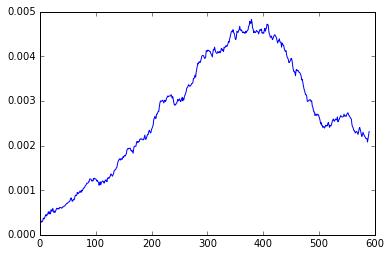

In [12]:
g.plot_reward(smoothing=100)

# Visualizing what the agent is seeing

Starting with the ray pointing all the way right, we have one row per ray in clockwise order.
The numbers for each ray are the following:
- first three numbers are normalized distances to the closest visible (intersecting with the ray) object. If no object is visible then all of them are $1$. If there's many objects in sight, then only the closest one is visible. The numbers represent distance to friend, enemy and wall in order.
- the last two numbers represent the speed of moving object (x and y components). Speed of wall is ... zero.

Finally the last two numbers in the representation correspond to speed of the hero.

In [18]:
g.__class__ = KarpathyGame
np.set_printoptions(formatter={'float': (lambda x: '%.2f' % (x,))})
x = g.observe()
new_shape = (x[:-2].shape[0]//g.eye_observation_size, g.eye_observation_size)
print(x[:-4].reshape(new_shape))
print(x[-4:])
g.to_html()

[[1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 0.83 1.00 -0.45 -0.46]
 [1.00 0.60 1.00 0.04 -0.47]
 [1.00 0.64 1.00 0.04 -0.47]
 [1.00 1.00 0.87 0.00 0.00]
 [1.00 1.00 0.60 0.00 0.00]
 [1.00 1.00 0.47 0.00 0.00]
 [1.00 1.00 0.40 0.00 0.00]
 [1.00 1.00 0.36 0.00 0.00]
 [1.00 1.00 0.34 0.00 0.00]
 [1.00 1.00 0.33 0.00 0.00]
 [1.00 1.00 0.34 0.00 0.00]
 [1.00 1.00 0.36 0.00 0.00]
 [1.00 1.00 0.40 0.00 0.00]
 [1.00 1.00 0.44 0.00 0.00]
 [1.00 1.00 0.37 0.00 0.00]
 [1.00 1.00 0.34 0.00 0.00]
 [1.00 1.00 0.32 0.00 0.00]
 [1.00 1.00 0.31 0.00 0.00]
 [1.00 1.00 0.32 0.00 0.00]
 [1.00 1.00 0.34 0.00 0.00]
 [1.00 1.00 0.37 0.00 0.00]
 [1.00 1.00 0.44 0.00 0.00]
 [1.00 1.00 0.56 0.00 0.00]
 [1.00 1.00 0.81 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]]
[-0.03 0.41 -0.89 -0.85]


<tf_rl.utils.svg.Scene instance at 0x10e9783f8>

In [8]:
# create the game simulator
g2 = KarpathyGame(current_settings)

In [94]:
human_control = False

if human_control:
    # WSAD CONTROL (requires extra setup - check out README)
    current_controller = HumanController({b"w": 3, b"d": 0, b"s": 1,b"a": 2,}) 
else:
    # Tensorflow business - it is always good to reset a graph before creating a new controller.
    tf.reset_default_graph()
    #session = tf.InteractiveSession()
    session = tf.Session()
    session.as_default()

    # This little guy will let us run tensorboard
    #      tensorboard --logdir [LOG_DIR]
    journalist = tf.train.SummaryWriter(LOG_DIR)

    # Brain maps from observation to Q values for different actions.
    # Here it is a done using a multi layer perceptron with 2 hidden
    # layers
    brain = MLP([g.observation_size,], [200, 200, g.num_actions], 
                [tf.tanh, tf.tanh, tf.identity])
    
    # The optimizer to use. Here we use RMSProp as recommended
    # by the publication
    optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

    # DiscreteDeepQ object
    current_controller = DiscreteDeepQ(g.observation_size, g.num_actions, brain, optimizer, session,
                                       discount_rate=0.99, exploration_period=0, max_experience=10000, 
                                       store_every_nth=4, train_every_nth=4,
                                       summary_writer=journalist, 
                                       restore_path=LOG_DIR+"/mlp.model.chkpt-400")
    
    session.run(tf.initialize_all_variables())
    session.run(current_controller.target_network_update)
    # graph was not available when journalist was created  
    journalist.add_graph(session.graph_def)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /var/folders/z_/203rtb2d141_z05gbwlvwg6c009kh1/T/tmp44nKdU/mlp.model.chkpt
	 [[Node: save/restore_slice = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/restore_slice/tensor_name, save/restore_slice/shape_and_slice)]]
Caused by op u'save/restore_slice', defined at:
  File "/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-94-b838735c10ce>", line 32, in <module>
    restore_path=LOG_DIR+"/mlp.model.chkpt")
  File "tf_rl/controller/discrete_deepq.py", line 111, in __init__
    max_to_keep=None)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 784, in __init__
    restore_sequentially=restore_sequentially)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 454, in build
    filename_tensor, vars_to_save, restore_sequentially, reshape)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 212, in _AddRestoreOps
    values = self.restore_op(filename_tensor, vs, preferred_shard)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 127, in restore_op
    preferred_shard=preferred_shard)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/io_ops.py", line 193, in _restore_slice
    preferred_shard, name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 271, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 655, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2040, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1087, in __init__
    self._traceback = _extract_stack()


In [10]:
FPS          = 30
ACTION_EVERY = 3
    
fast_mode = True
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 1
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    with tf.device("/cpu:0"):
        current_controller.exploration_period = 0
        simulate(simulation=g2,
                 controller=current_controller,
                 fps=FPS,
                 visualize_every=VISUALIZE_EVERY,
                 action_every=ACTION_EVERY,
                 wait=WAIT,
                 disable_training=True,
                 simulation_resolution=0.001,
                 max_frame=3000,
                 save_path=None)
except KeyboardInterrupt:
    print("Interrupted")

<tf_rl.utils.svg.Scene instance at 0x1069f2b90>

Interrupted
